In [1]:
import pandas as pd
!pip install openpyxl

In [2]:
df=pd.read_excel("Customer_Churn_Data_Large.xlsx")

In [3]:
xls = pd.ExcelFile("Customer_Churn_Data_Large.xlsx")

#Loading each sheet explicitly
df_demo = xls.parse("Customer_Demographics")
df_trans = xls.parse("Transaction_History")
df_service = xls.parse("Customer_Service")
df_online = xls.parse("Online_Activity")
df_churn = xls.parse("Churn_Status")

In [4]:
print(df_demo.head())
print(df_trans.head())
print(df_service.head())
print(df_online.head())
print(df_churn.head())

   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing
   CustomerID  InteractionID InteractionDate InteractionType ResolutionStatus
0           1           6363      2022-03-31         Inquiry         Resolved
1           2           3329      2022-03-17         Inquiry         Resolved
2         

# Step1: Pre-Aggregate Sheets with Multiple Rows per Customer

#### Some Sheets have many rows per CustomerID (like df_trans and df_service). You can't directly merge those; you must first summarize (aggregate) them.

#### Transaction History: Aggregate per customer

In [5]:
df_trans_agg = df_trans.groupby("CustomerID").agg({
    "AmountSpent": "sum",                    #Total amount spent
    "ProductCategory": lambda x: x.mode()[0] if not x.mode().empty else "Unknown"  #Most bought category
}).reset_index()

#### Customer Service: Aggregate per customer

In [6]:
df_service_agg = df_service.groupby("CustomerID").agg({
    "InteractionID": "count",    #Totak Interactions
    "ResolutionStatus": lambda x: (x == "Unresolved").sum() # Count of unresolved cases
}).rename(columns={
    "InteractionID": "TotalInteractions",
    "ResolutionStatus": "UnresolvedCases"
}).reset_index()

#### Online Activity

In [7]:
df_online_clean = df_online.copy()

# Step2: Merge Everything on Customer ID

In [8]:
# Start with demographics
df_master = df_demo.copy()

# Join with aggregated transaction data
df_master = df_master.merge(df_trans_agg, on="CustomerID", how="left")

# Join with aggregated service data
df_master = df_master.merge(df_service_agg, on="CustomerID", how="left")

# Join with online activity
df_master = df_master.merge(df_online_clean, on="CustomerID", how="left")

# Finally, join with churn label
df_master = df_master.merge(df_churn, on="CustomerID", how="left")

In [9]:
print(df_master.shape)
print(df_master.info())
print(df_master.head())

(1000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerID         1000 non-null   int64         
 1   Age                1000 non-null   int64         
 2   Gender             1000 non-null   object        
 3   MaritalStatus      1000 non-null   object        
 4   IncomeLevel        1000 non-null   object        
 5   AmountSpent        1000 non-null   float64       
 6   ProductCategory    1000 non-null   object        
 7   TotalInteractions  668 non-null    float64       
 8   UnresolvedCases    668 non-null    float64       
 9   LastLoginDate      1000 non-null   datetime64[ns]
 10  LoginFrequency     1000 non-null   int64         
 11  ServiceUsage       1000 non-null   object        
 12  ChurnStatus        1000 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)

In [10]:
print(df_master.isnull().sum())

CustomerID             0
Age                    0
Gender                 0
MaritalStatus          0
IncomeLevel            0
AmountSpent            0
ProductCategory        0
TotalInteractions    332
UnresolvedCases      332
LastLoginDate          0
LoginFrequency         0
ServiceUsage           0
ChurnStatus            0
dtype: int64


In [11]:
df_master['TotalInteractions']=df_master['TotalInteractions'].fillna(0)
df_master['UnresolvedCases']=df_master['UnresolvedCases'].fillna(0)

### Churn Distribution

/var/folders/dh/6lwkx0l90tz3dvbqfhcww_540000gq/T/ipykernel_4273/4217646647.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_master, x='Churn Label', palette=['#1f77b4', '#ff7f0e'])


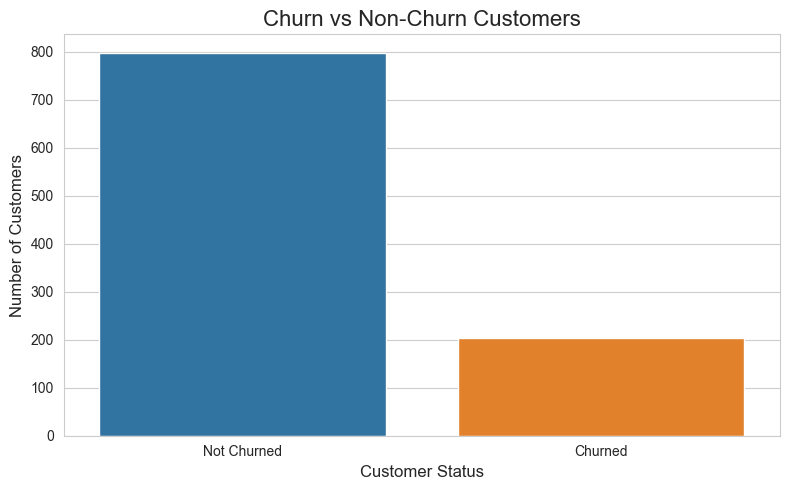

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column with readable labels
df_master['Churn Label'] = df_master['ChurnStatus'].map({0: 'Not Churned', 1: 'Churned'})

# Set style
sns.set_style("whitegrid")

# Plot with colors and labels
plt.figure(figsize=(8,5))
sns.countplot(data=df_master, x='Churn Label', palette=['#1f77b4', '#ff7f0e'])

plt.title("Churn vs Non-Churn Customers", fontsize=16)
plt.xlabel("Customer Status", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/dh/6lwkx0l90tz3dvbqfhcww_540000gq/T/ipykernel_4273/139974299.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_master, x='Churn Label', palette=["#1f77b4", "#ff7f0e"])


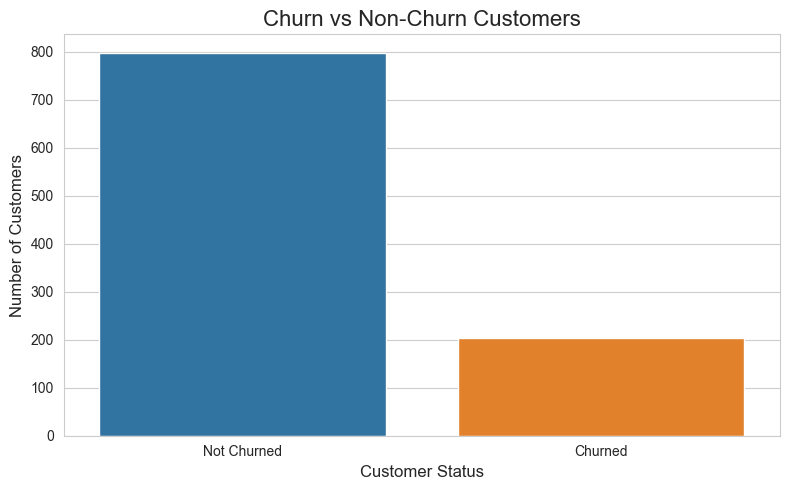

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df_master['Churn Label'] = df_master['ChurnStatus'].map({0: 'Not Churned', 1:'Churned'})
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(data=df_master, x='Churn Label', palette=["#1f77b4", "#ff7f0e"])

plt.title("Churn vs Non-Churn Customers", fontsize=16)
plt.xlabel("Customer Status", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.tight_layout()
plt.show()

# Step3: Churn vs Categorical Variables

### Gender vs Churn

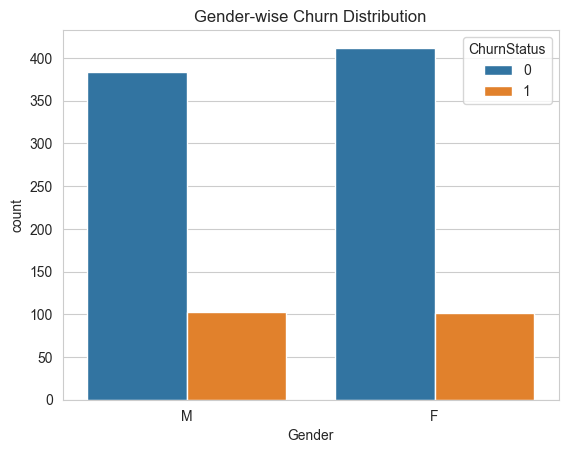

In [14]:
sns.countplot(data=df_master, x='Gender', hue='ChurnStatus')
plt.title("Gender-wise Churn Distribution")
plt.show()

### Income Level vs Churn

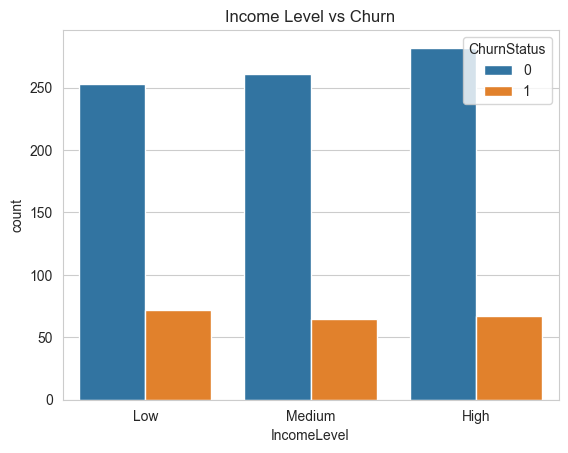

In [15]:
sns.countplot(data=df_master, x='IncomeLevel', hue='ChurnStatus')
plt.title("Income Level vs Churn")
plt.show()

### Service Usage vs Churn

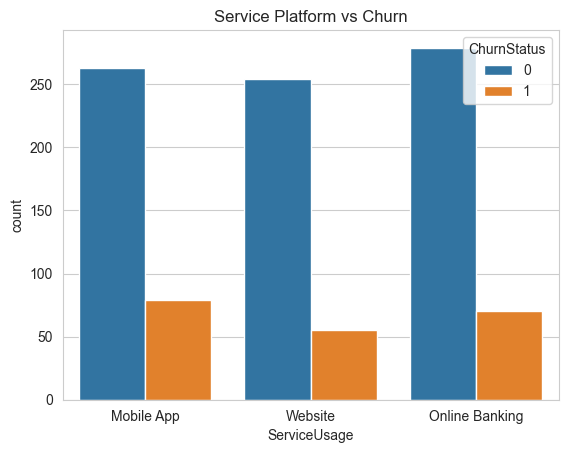

In [16]:
sns.countplot(data=df_master, x='ServiceUsage', hue='ChurnStatus')
plt.title("Service Platform vs Churn")
plt.show()

# Step4: Churn vs Numeric Features


### Login Frequency vs Churn

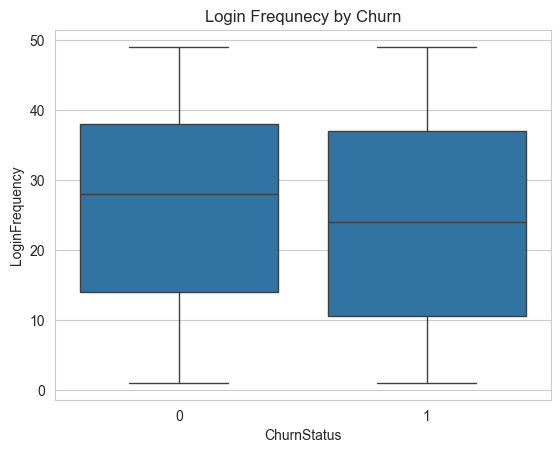

In [17]:
sns.boxplot(data=df_master, x='ChurnStatus', y='LoginFrequency')
plt.title("Login Frequnecy by Churn")
plt.show()

### Amount Spent vs Churn

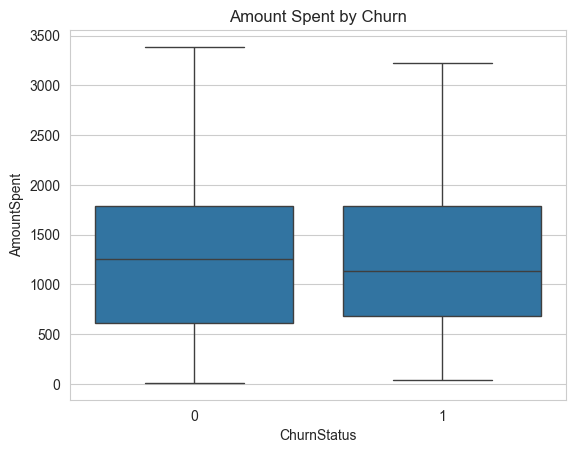

In [18]:
sns.boxplot(data=df_master, x='ChurnStatus', y='AmountSpent')
plt.title("Amount Spent by Churn")
plt.show()

### Unresolved Cases vs Churn

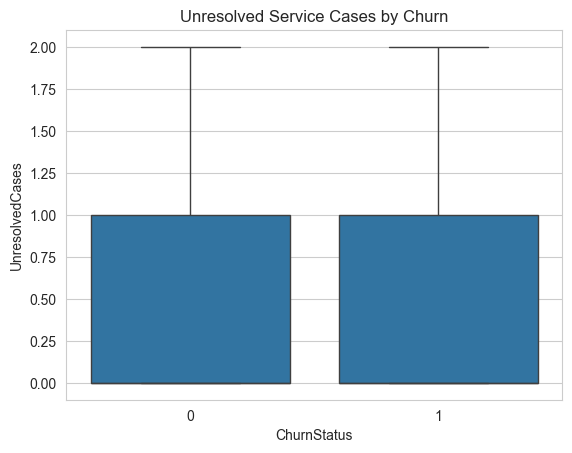

In [19]:
sns.boxplot(data=df_master, x='ChurnStatus', y='UnresolvedCases')
plt.title("Unresolved Service Cases by Churn")
plt.show()

In [20]:
df_master.to_excel("Cleaned_Customer_Churn_Data.xlsx", index=False)

In [21]:
print(df_master.columns.tolist())


['CustomerID', 'Age', 'Gender', 'MaritalStatus', 'IncomeLevel', 'AmountSpent', 'ProductCategory', 'TotalInteractions', 'UnresolvedCases', 'LastLoginDate', 'LoginFrequency', 'ServiceUsage', 'ChurnStatus', 'Churn Label']


# Training the Model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pandas as pd


### Split the data

In [23]:
y = df_master['ChurnStatus']
X = df_master.drop(['ChurnStatus', 'Churn Label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

### Train the Model


In [24]:
# X = df_master.drop(columns=['ChurnStatus', 'LastLoginDate']) 
# y = df_master['ChurnStatus']

# X_encoded = pd.get_dummies(X, drop_first=True)

In [25]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y, stratify=y, test_size=0.2, random_state=42
# )

In [26]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# print("Accuracy:" ,accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

In [27]:
# print(X_encoded.shape)  # How many rows total?
# print(X_train.shape, X_test.shape)  # Should be 80/20 split


In [28]:
# print(y_test.value_counts(normalize=True))  # Check how many 0s and 1s


In [29]:
# from sklearn.metrics import confusion_matrix

# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [38]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled= smote.fit_resample(X_encoded,y)

In [39]:
X = df_master.drop(columns=['CustomerID', 'ChurnStatus', 'LastLoginDate'])  # Drop ID!


In [40]:
X = df_master.drop(columns=['ChurnStatus', 'LastLoginDate', 'Churn Label'])  # drop it
X_encoded = pd.get_dummies(X, drop_first=True)


In [41]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [42]:
# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [43]:
# Re-train
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [45]:
# Re-evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))

Accuracy: 0.8369905956112853
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       160
           1       0.87      0.79      0.83       159

    accuracy                           0.84       319
   macro avg       0.84      0.84      0.84       319
weighted avg       0.84      0.84      0.84       319

Confusion Matrix:
 [[142  18]
 [ 34 125]]


In [46]:
print(X_encoded.columns.tolist())


['CustomerID', 'Age', 'AmountSpent', 'TotalInteractions', 'UnresolvedCases', 'LoginFrequency', 'Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widowed', 'IncomeLevel_Low', 'IncomeLevel_Medium', 'ProductCategory_Clothing', 'ProductCategory_Electronics', 'ProductCategory_Furniture', 'ProductCategory_Groceries', 'ServiceUsage_Online Banking', 'ServiceUsage_Website']


In [47]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)
print("After SMOTE:", X_resampled.shape, y_resampled.value_counts())

After SMOTE: (1592, 18) ChurnStatus
0    796
1    796
Name: count, dtype: int64


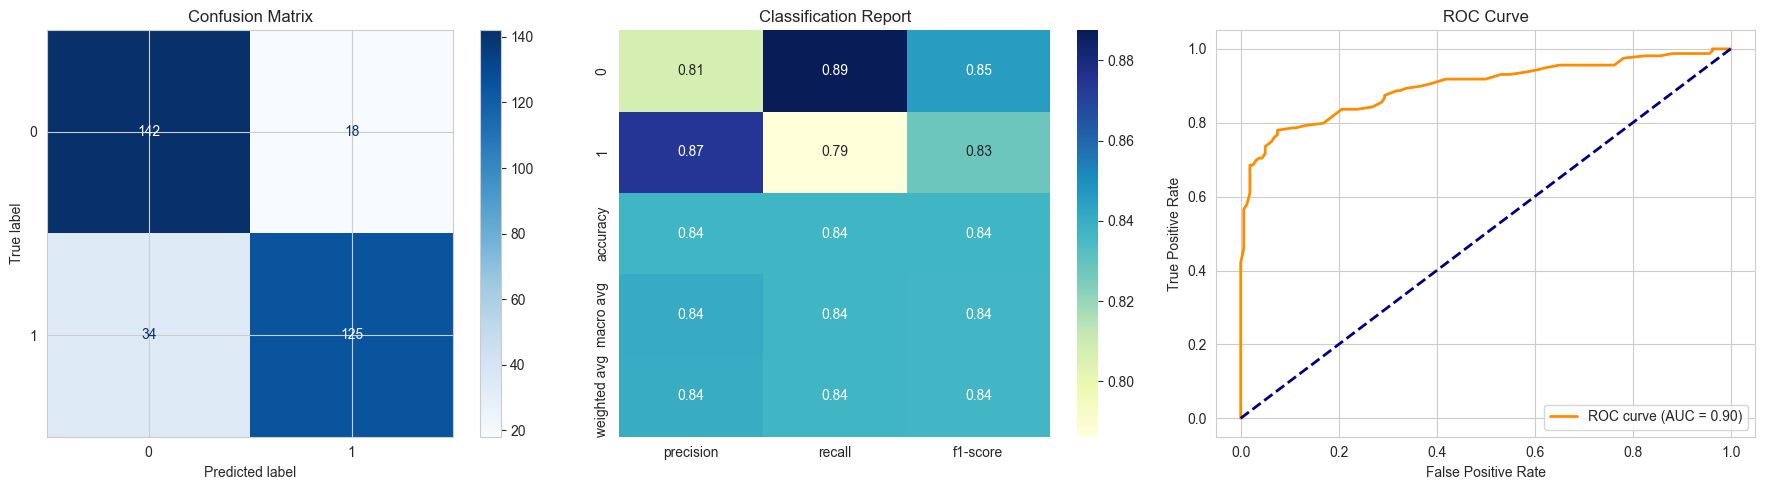

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities for ROC
y_probs = model.predict_proba(X_test)[:, 1]

# Create a figure
plt.figure(figsize=(18, 5))

# ---- 1. Confusion Matrix ----
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
plt.title('Confusion Matrix')

# ---- 2. Classification Report (as heatmap) ----
plt.subplot(1, 3, 2)
report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title('Classification Report')

# ---- 3. ROC-AUC Curve ----
plt.subplot(1, 3, 3)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# ---- Finalize ----
plt.tight_layout()
plt.savefig("evaluation_metrics.png", dpi=300)  # Save as PNG
plt.show()
